# Trend filtering

Using this project as a point of testing this ideas I've had for awhile now, I want to use this notebook as a means through which to explore the utility of a Bayesian filter on the trend signal ingestion process. Specifically, I want to first look at the trend signal itself (1 or 0) as a noisy observation of an underlying (hidden) markov model, and run a Bayesian filter over it to effectively do a more rigorous approach to the 'confidence' that we have in the reality of the signal.

Next, I wanted to generalize this concept to look at the signal strength as the input variable, either in a binned sense, or as a continuous input signal differentiating from an underlying discrete signal (look at E. Lathouwers & J. Bechhoefer, *Phys. Rev. E*, **2015** for guidance)

#### Markov Models

As it pertains to trend-following, we assume that there is a discrete set of states $x_k$ where $k\in[0, N]$. The goal is to determine the probability P(x_k=i)--the probability that the system is in state $x_k = i$ at time $k$, and is subject to the normalization $\sum_i P(x_k) = 1$. Given that the state dynamics are *Markovian* the dynamics are completely specified by $P(x_{k+1}| x_k)$ and are known often as *Markov Chains*.  The dynamics take the form of an $N\times N$ matrix (the transition matrix) $\boldsymbol{A}$ with entries
$$ A_{ij} \equiv P(x_{k+1} = i | x_{k} = j)$$
and satisfy that $A_{ij}\in[0, 1]$ so that $A_{ij}$ gives the probability of a $j\to i$ state transition.

If we are concerned with a basic implementation of trend where there are only 2 states (up-trend and down-trend) then the 2-state system is a $2\times 2$ matrix:

$$
\boldsymbol{A} \equiv \left( \begin{matrix}
    1 - a_0 & a_1 \\
    a_0 & 1 - 1 - a_1
\end{matrix}
\right)
$$

where normalization implies that the sum over columns is unity: $\sum_i A_{ji} = 1$ (and so the matrix $\boldsymbol{A}$ is known as a *stochastic matrix*)

Now, the state of the system is given by an $N$-dimensional *stochastic vector* $\boldsymbol{p}_k$ with elements $p_k^{(j)} = P(x_k=j) \in [0, 1]$ and $\sum_j p_k^{(j)} = 1$. This vector represents the probability density over states of the system. 

Now, given the Markov dynamics of the state, the stochastic vector is updated using the transition matrix:

$$ p_{k+1}^{(i)} = \sum_{j=1}^n P(x_{k+1}=i, x_{k}=j) = \sum_{j=1}^n P(x_{k+1}=i | x_{k} = j)P(x_k=j) = \sum_{j=1}^N A_{ij}p_k^{(j)} $$

Or, in vector form: $\boldsymbol{p}_{k+1} = \boldsymbol{A}\boldsymbol{p}_k$. Furthermore, given that the dynamics are assumed to be stationary, we have that $\boldsymbol{p}_k = \boldsymbol{A}^k \boldsymbol{p}_0$.  Finally, at staeady state (when the system has lost all memory of its inital state) the probability vector satisfies $\boldsymbol{p}_{\rm ss} = \boldsymbol{A}\cdot\boldsymbol{p}_{\rm ss}$. The steady state can be found by either iterating the dynamics until this condition is fulfilled, or finding the (unique) eigenvector corresponding to the eigenvalue $\lambda=1$ of the transition matrix.


#### Hidden Markov Models

Hidden Markov Models (HMM) are a framework used to model systems in which the underlying dynamics are expected to be Markovian, but the observations  of the system are plagued by noise. Thus, while the system behaves under the simple Markovian dynamics discussed in the prevcious section, our noisy observations are not so simple. Specifically, at time $k$ the system is state $x_k$ and we observe the value $y_k$ (which is assumed to be one of the possible $x_k$ values for now).  However, if there is noise in the observations, then there is a possibility of observing the wrong state. For instance, if $x_k = 1$, we may observe $y_k = 0$. This motivates introducing an observation matrix $\boldsymbol{B}$ with elements $B_{ij} \equiv P(y_k = i | x_k = j)$. In the absence of observation noise, the observation matrix would be a diagonal matrix of ones (as it is also a stochastic matrix), and the magnitude of off-diagonal vaies indicate the probabilities of errors in observations. 

There are two paths forward in treating HMMs:
* State Estimation
* System Identification

For now, we focus on the former. Now, there are a few different types of estimation, depending on the type of information available:
* **Filtering** - Estimating $P(x_k | y^k)$, the probability of each state ($x_k$) based on the sequence of previous observations ($y^k$) 
* **Smoothing** - Estimating $P(x_k | y^N)$, the probability of each state ($x_k$) based on both past *and* future observations ($y^N$)
* **Optimal Path Estimation** - Maximum *a postiori* estimation of the most-probable trajectory of the system state ($x^N$) using all (past and future) observations ($\text{Argmax}_{x^N}P(x^N|y^N)$)

For the purposes of trend-following, we are primarily interested in **Filtering**, but **smoothing** and **Optimal Path Estimation** may be useful in benchmarking the true performance of different trend-following procedures.

For filtering, we want to determine two probability distributions:
* $P(x_{k+1}| x^k, y^k)$ - The probability of the next system state, given the previous sequence of states and observations
* $P(y_k | x^k, y^{k-1})$ - The probability of an observation, given the system state at the current time, and the history of previous observations

Using Bayes theorem, the Markov property of the state dynamics, and the momoryless property of observations (past observations do not affect future observations) we can make the simplifications

$$ P(x_{k+1}| x^k, y^k) = P(x_{k+1} | x_k) $$
$$ P(y_k | x^k, y^{k-1}) = P(y_k | x_k) $$

Which leads to the so-called *Bayesian Filtering equations*, a two-step procedure that predicts, and updates our estimates of the system state based on a sequence of observed trajectories:

$$ P(x_{k+1}|y^k) = \sum_{x_k}P(x_{k+1}|x_k)P(x_k | y^k) \qquad \text{(Prediction)}$$
$$ P(x_{k+1}| y^{k+1}) = \frac{1}{Z_{k+1}}P(y_{k+1} | x_{k+1})P(x_{k+1}| y^k) \qquad \text{(Update)} $$

where $Z_{k+1}$ is a *partition function* defined as

$$ Z_{k+1} \equiv P(y_{k+1}| y^k) = \sum_{x_{k+1}}P(y_{k+1} | x_{k+1})P(x_{k+1} | y^k) $$

Iterating these steps will propagate the conditional probability $P(x_k | y^k)$ through time, allowing us to estimate the probabilty of a given state based on noisy observations.

However, up until this point, we have assumed that we *know* the transition and observation matrices, which will not be the case for trend-following. This is where the second part of the treatment of HMMs comes into play (system identification).  In developing the algorithms and logic for running the Bayesian filtering, in this notebook we run analysis for a known set of transition and measurement error matrices, and discuss the more practuical scenario in a subsequent notebook

In [1]:
# To start, load in libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

import seaborn as sns

In [4]:
# First, define a set of measurement and observation matrices for a 2-state system

def stochastic_matrix(a_1, a_2):
    return np.array([[1 - a_1, a_2],[a_1, 1 - a_2]])

def initialize_probability(dim=2):
    prob = np.zeros(dim)
    prob[np.random.randint(dim)] = 1
    return prob

# Assume a transition rate of 0.1 (symmetrically) in the transition matrix
A = stochastic_matrix(0.1, 0.1)
# And an observation error of 0.05 (also symmetric)
B = stochastic_matrix(0.05, 0.05)

# also instantiate the probability vector to a random initial state
prob = initialize_probability()

A, B, prob

(array([[0.9, 0.1],
        [0.1, 0.9]]),
 array([[0.95, 0.05],
        [0.05, 0.95]]),
 array([0., 1.]))

In [5]:
# Now to propagate a single trajectory of the dynamics, we want to run a kinetic monte carlo trajectory
# Specifically, we select a random next-state in accordance with the transition probabilities of the current system state

def step_dynamics(p, A):
    # The set of possible transitions are given by the column corresponding to the current state
    trans_prob = A[:, np.argmax(p)]

    # Because this is a two-state system, we can simply select the state based on whether a random number is greater than the first entry of the matrix
    w = np.random.uniform()
    if w < trans_prob[0]:
        p = np.array([1, 0])
    else:
        p = np.array([0, 1])
    return p


In [15]:
# Now to generate a trajectory, we can simply apply namy iterations of the 'step_dynamics' routine to the inital state

trajectory = []
steps = 250
prob = initialize_probability()
for _ in range(steps):
    prob = step_dynamics(prob, A)
    trajectory.append(np.argmax(prob))

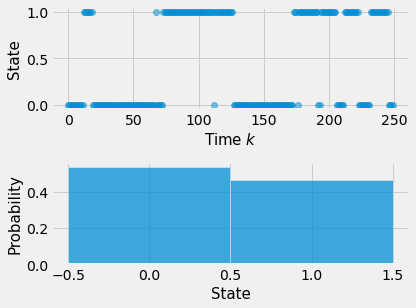

In [17]:
# Now plot the time series of states
fig, ax = plt.subplots(2, 1, figsize=(6, 4.5))
ax[0].plot(trajectory, 'o', alpha=0.5)
binEdges = [-0.5, 0.5, 1.5]
sns.histplot(trajectory, stat="density", ax=ax[1], bins=binEdges)

ax[0].set_xlabel(r"Time $k$", fontsize=15)
ax[0].set_ylabel(r"State", fontsize=15)

ax[1].set_xlabel(r"State", fontsize=15)
ax[1].set_ylabel(r"Probability", fontsize=15)
plt.tight_layout()

In [24]:
# Now, we want to model the observed data series, which is simply the true state multiplied by the bservation matrix: y = B * prob

def hidden_markov_trajectory(A, B, iterations):
    true_traj = []
    obs_traj = []

    prob = initialize_probability()

    for _ in range(iterations):
        prob = step_dynamics(prob, A)
        obs = step_dynamics(prob, B)

        true_traj.append(np.argmax(prob))
        obs_traj.append(np.argmax(obs))

    return np.array(true_traj), np.array(obs_traj)


In [26]:
# Now we can generate sampe observation and true trajectories

state_traj, obs_traj = hidden_markov_trajectory(A, B, 1000)

# Here, we should see an error rate of ~5%
error_rate = np.mean(np.abs(state_traj - obs_traj))
error_rate

0.047

In [27]:
# Now we want to implement the Bayesian filter.

# Our initial 'prior' is that the initial observation is correct, so the conditional probability p(x|y) is teh state vector
def filter_estimate(bayes_prob, A, B):
    # Prediction step: based on current conditional probability P(x_k|y^k), waht is the probability distribution over states x_{k+1}
    # This is simply A * P(x_k|y^k)
    bayes_predict = np.matmul(A, bayes_prob)

    # Update step: now we want the current probabiltiy estimate, given an observation y_{k+1}: P(x_{k+1} | y^{k+1})
    # Using Bayes theorem this is simply the product of the probability distribution over x states, multiplied by the observation matrix,
    # which quantifies the relative probabilities of errors occurring in that process
    bayes_update = np.matmul(B, bayes_predict)
    bayes_update /= np.sum(bayes_update)

    # Return the estimate of P(x_{k+1}| y^{k+1})
    return bayes_update



In [50]:
# Now we can test this, calculating the true trajectory, observed trajectory, and the probability distribution over states as a sunction of time
# We assume that the initial prediction is naive

bayes_est = np.array([0.5, 0.5])
prob = initialize_probability()

def run_simulation_bayes(A, B, prob, bayes_est, iterations=50):
    traj_tracker = [np.argmax(prob)]
    obs_tracker = [np.argmax(prob)]
    filter_tracker = [bayes_est]

    for _ in range(iterations):
        prob = step_dynamics(prob, A)
        obs = np.argmax(step_dynamics(prob, B))

        bayes_est = np.matmul(A, bayes_est)
        # bayes_filter = np.zeros_like(prob)

        # for i, p in enumerate(prob):
        #    bayes_filter[i] = B[obs, i] * p
        bayes_filter = B[:, obs] * bayes_est
        bayes_est = bayes_filter / np.sum(bayes_filter)

        filter_tracker.append(bayes_est)
        traj_tracker.append(np.argmax(prob))
        obs_tracker.append(obs)

    return filter_tracker, traj_tracker, obs_tracker

filter_tracker, traj_tracker, obs_tracker = run_simulation_bayes(A, B, prob, bayes_est)


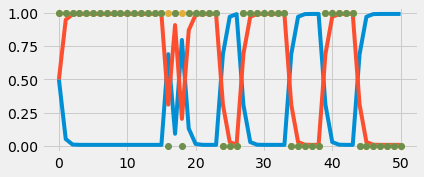

In [57]:
np.array(filter_tracker)[:, 0]
filter_tracker = np.array(filter_tracker)

fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))

ax.plot(filter_tracker[:, 0])
ax.plot(filter_tracker[:, 1])

ax.plot(traj_tracker, 'o')
ax.plot(obs_tracker, 'o')



In [59]:
# Now, we can generalize/formalize the filter predictor a bit better
def bayesian_filter(A: np.ndarray, B: np.ndarray, bayes_prob: np.ndarray, obs: int):
    bayes_prob = np.matmul(A, bayes_prob)           # Prediction step
    bayes_filter = B[:, obs] * bayes_prob           # Update step
    return bayes_filter / np.sum(bayes_filter)      # Normalization

Now, given this implementation of a Bayesian Filter, we can apply this conditioanl logic to the application of Trend-followign in financial markets

Specifically, in trend-following, we act (into the market or out-of-the market) based on a trend-signal, which is often the comparison of a simple of exponentially-weighted
moving average with the current price level. The binary output of the signal is then used as a direct indicator of the market state. Applying this Bayesuian filtering to such a signal outut could help significantly in quantifying a phenomenon known as `persistence': the belief that a signal that persists in time is more believable (and not, for instance, a signal produced purely due to noise). Additionally, the continuous nature of the Bayesian posterior allows one to interpolate in levels of confidence as well, for inatnce, by adjusting the confidence threshold to act on a trade, potentially even with a hysteretic consideration, as trade-action incurs a cost, thus we may want to impose a confidence burden on the models before action is taken.

Furthermore, this can be used in conjunction with an ensemble-based model approach. For long-memory moving average models, signals are relatively long-lived, and thus (while the signals themselved maybe be low-fidelty) remain relatively robust to change over short time horizons. We expect that the Bayeisn filters will be most impactful in intermediate regimes, where the Signal to Noise Ratio (SNR) is moderate. Here, there is enough information in the history of shignal changes to understand the hidden dynamics better than naive observation, but the signals are not too noisy that any prediction is a lost cause. 

In the followign notebooks, we will first implement a Bayesian smoothing algorithm to act as a simplistic 'Oracle' determinant, that will be used as a source-of-truth as to the true state of the market for a given estimator, and then implement a parameter-determination estimation procedure to infer the parameters of the A and B matrix in the absence of their knowledge